# Generate adversarial patch

In [4]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
from torchvision import models, datasets

from data_utils.data_setup import get_imagenet_classes, get_top_prediction, get_imagenet_test
from techniques.gen_patch import gen_adversarial_patch
from metrics.utils import *
from techniques.generate_grounding import gen_grounding

datadir = '../data/test/'
#datadir = '../data/ILSVRC2012_img_val/'

In [5]:
import json

def find_label(target):
    with open('../data/imagenet_class_index.json', 'r') as f:
        labels = json.load(f)
    for key in labels:
        index, label = labels[key]
        if index == target:
            return label, key
            
find_label('n01440764')

('tench', '0')

In [6]:
dataset, data_loader = get_imagenet_test(datadir=datadir, shuffle=True)
labels = list(os.walk(datadir))[0][1]
list.sort(labels)
print(labels)

['n01930112', 'n01981276', 'n02099601', 'n02110063', 'n02110341', 'n02116738', 'n02129165', 'n02219486', 'n02443484', 'n02871525', 'n03127925', 'n03146219', 'n03272010', 'n03544143', 'n03775546', 'n04146614', 'n04149813', 'n04418357', 'n04522168', 'n07613480']


tensor([8])
ground truth class: black-footed_ferret
predicted clas: polecat


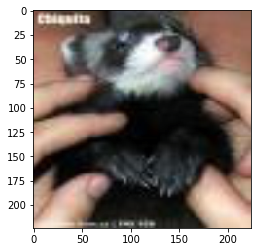

In [8]:
j=0
for i, (inp, label) in enumerate(data_loader):
    if j<1:
        print(label)
        gt_label = labels[label.numpy()[0]]
        gt_label_name, gt_label_idx = find_label(gt_label)
        print('ground truth class: {0}'.format(gt_label_name))
        img = inp[0].numpy().transpose((1, 2, 0))
        label_name = get_imagenet_classes()[label.numpy()[0]]
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        displ_img = std * img + mean
        displ_img = np.clip(displ_img, 0, 1)
        displ_img /= np.max(displ_img)
        patch_img = displ_img
        displ_img = np.uint8(displ_img*255)
        label_name, label_idx = get_top_prediction('vgg19', inp)
        print('predicted clas: {0}'.format(label_name))
        if label_name == gt_label_name:
            print('correct cclasssification')
        plt.imshow(displ_img)
    else:
        break
    j+=1
    

USING CUDA ---------------------


/work/lisabdunlap/explain-eval/techniques/fooling_network_interpretation/gradcam_targeted_patch_attack.py:401: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  index_prob = torch.nn.functional.softmax(output)[0][index]




Regular adversarial patch attack:


Before attack, Predicted class:polecat	Target class:mailbag

Iteration:0	CE Loss:22.228	total_pert.mean:0.005	Orig index:polecat	Target index:mailbag	Pred index:black-footed_ferret
Iteration:10	CE Loss:15.488	total_pert.mean:0.046	Orig index:polecat	Target index:mailbag	Pred index:black-footed_ferret
Iteration:20	CE Loss:13.724	total_pert.mean:0.086	Orig index:polecat	Target index:mailbag	Pred index:black-footed_ferret
Iteration:30	CE Loss:12.133	total_pert.mean:0.126	Orig index:polecat	Target index:mailbag	Pred index:black-footed_ferret
Iteration:40	CE Loss:10.407	total_pert.mean:0.164	Orig index:polecat	Target index:mailbag	Pred index:black-footed_ferret
Iteration:50	CE Loss:8.939	total_pert.mean:0.200	Orig index:polecat	Target index:mailbag	Pred index:black-footed_ferret
Iteration:60	CE Loss:7.701	total_pert.mean:0.235	Orig index:polecat	Target index:mailbag	Pred index:polecat
Iteration:70	CE Loss:6.510	total_pert.mean:0.266	Orig index:polecat	T

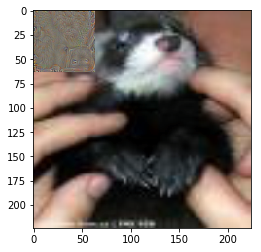

In [9]:
reg_patch_adv_img, reg_patch_adv_mask, target_index = gen_adversarial_patch(displ_img, 'vgg19', label_name)

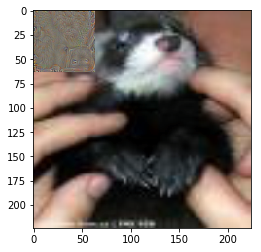

In [10]:
plt.imshow(reg_patch_adv_img)

In [17]:
save_path='../results/explanation_examples/'
gcam_expl = gen_grounding(reg_patch_adv_img, 'vgg19', 'ig', gt_label_name, show=True, save=True, save_path=save_path, label_index = i, patch=True)

result path: ../results/explanation_examples/black-footed_ferret/black-footed_ferret-04-Dec-2019_08/patch/


Generating filters:   0%|          | 0/6000 [00:00<?, ?it/s]/work/lisabdunlap/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Generating filters: 100%|██████████| 6000/6000 [00:19<00:00, 310.36it/s]


Masks are generated.


RuntimeError: CUDA out of memory. Tried to allocate 3.37 GiB (GPU 0; 11.91 GiB total capacity; 4.72 GiB already allocated; 2.13 GiB free; 22.92 MiB cached)

In [ ]:
gcam_expl = gen_grounding(displ_img, 'vgg19', 'ig', gt_label_name, show=True, save=True, save_path=save_path, label_index = i)

In [29]:
from torchvision import transforms
from PIL import Image
import torch
import torch.nn.functional as F

read_tensor = transforms.Compose([
    lambda x: x,
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    lambda x: torch.unsqueeze(x, 0)
])

img = Image.fromarray(np.uint8(reg_patch_adv_img*255).astype('uint8'), 'RGB')

print(get_top_prediction('vgg19', read_tensor(img)))

('box_turtle', 37, 0.9996823)


[1.00000] box_turtle


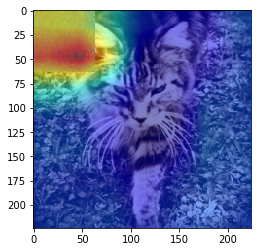

In [46]:
gcam_expl, gcam_mask = gen_grounding(patch, 'vgg19', 'gcam', label_name, show=True)

original lime thingy: box_turtle
lime classsification: 37
show


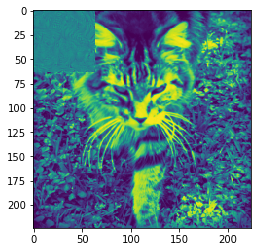

In [39]:
lime_expl, lime_mask = gen_grounding(np.uint8(reg_patch_adv_img*255), 'vgg19', 'lime', label_name, show=True)

patch iou: 0.8045602605863192
percent covered: 0.96484375


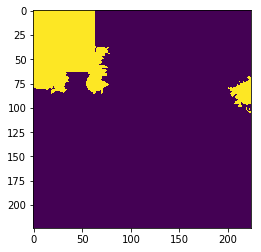

In [40]:
from metrics.patch_intersection import *
plt.imshow(lime_mask)
print("patch iou: {0}".format(patch_iou(lime_mask, threshold=10)))
print("percent covered: {0}".format(percent_covered(lime_mask, threshold=10)))

Generating filters: 100%|██████████| 6000/6000 [00:13<00:00, 447.31it/s]


Masks are generated.
got to stack


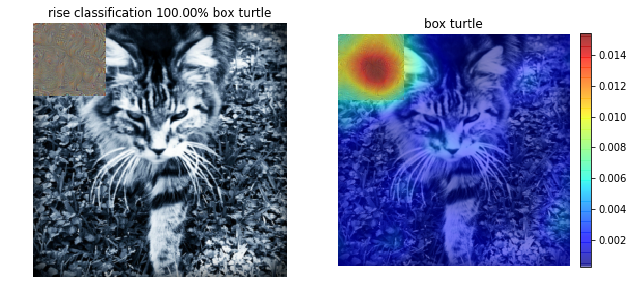

In [31]:
#from PIL import Image
rise_expl_patch, rise_mask_patch = gen_grounding(np.uint8(reg_patch_adv_img*255), 'vgg19', 'rise', label_name, show=True)

In [33]:
from metrics.patch_intersection import *
print("patch iou: {0}".format(patch_iou(rise_mask_patch, threshold=10)))
print("percent covered: {0}".format(percent_covered(rise_mask_patch, threshold=10)))

patch iou: 0.8138700677560781
percent covered: 0.9970703125


## Explanations

[0.52381] spaghetti_squash


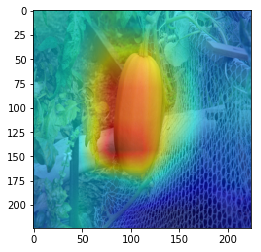

In [41]:
gcam_expl, gcam_mask = gen_grounding(np.uint8(displ_img*255), 'vgg19', 'gcam', label_name, show=True)

In [ ]:
gcam_expl, gcam_mask = gen_grounding(np.uint8(displ_img*255), 'vgg19', 'gcam', label_name, show=True)

In [ ]:
#from PIL import Image
lime_expl, lime_mask = gen_grounding(np.uint8(displ_img*255), 'vgg19', 'lime', label_name, show=True)

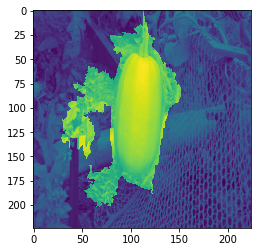

In [85]:
cam = displ_img[:, :, 1] + lime_mask
plt.imshow(cam)

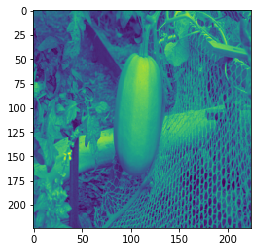

In [63]:
ig_expl, ig_mask = gen_grounding(np.uint8(displ_img*255), 'vgg19', 'ig', label_name, show=True)

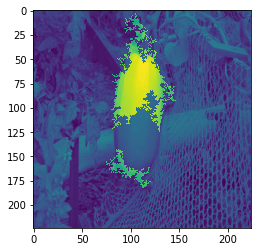

In [74]:
ig_copy = ig_mask
ig_copy[ig_copy == 255] = 1
cam = displ_img[:, :, 1] + ig_copy
#cam = np.load('../results/explanation_examples/spaghetti_squash/ig-2019-11-08-16-07.png.npy')
plt.imsave('../results/explanation_examples/spaghetti_squash/ig-2019-11-08-16-07.png', cam)
plt.imshow(cam)